[View in Colaboratory](https://colab.research.google.com/github/avs20/HOG_Playground/blob/master/HOG_Digits.ipynb)

In [0]:
#install opencv 
# !apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

In [0]:
### COMMON UTILITIES

from functools import reduce

import numpy as np
import cv2

# built-in modules
import os
import itertools as it
from contextlib import contextmanager

PY3 = True

image_extensions = ['.bmp', '.jpg', '.jpeg', '.png', '.tif', '.tiff', '.pbm', '.pgm', '.ppm']


def clock():
    return cv2.getTickCount() / cv2.getTickFrequency()

@contextmanager
def Timer(msg):
    print(msg, '...',)
    start = clock()
    try:
        yield
    finally:
        print("%.2f ms" % ((clock()-start)*1000))



def mosaic(w, imgs):
    '''Make a grid from images.

    w    -- number of grid columns
    imgs -- images (must have same size and format)
    '''
    imgs = iter(imgs)
    PY3 = True
    if PY3:
        img0 = next(imgs)
    else:
        img0 = imgs.next()
    pad = np.zeros_like(img0)
    imgs = it.chain([img0], imgs)
    rows = grouper(w, imgs, pad)
    return np.vstack(map(np.hstack, rows))



In [6]:
from google.colab import files

uploaded = files.upload()

Saving digits.png to digits.png


Loading digits from digits.png ... 
Shuffle data ... 
Deskew images ... 
Defining HoG parameters ...
Calculating HoG descriptor for every image ... 
Spliting data into training (90%) and test set (10%)... 
Training SVM model ...
Saving SVM model ...
Evaluating model ... 
Accuracy: 98.60 %
confusion matrix:
[[52  0  0  0  0  0  0  0  0  0]
 [ 0 42  1  0  0  0  0  2  0  0]
 [ 0  0 60  1  0  0  0  1  0  0]
 [ 0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0 51  0  0]
 [ 0  0  0  0  0  1  0  0 50  0]
 [ 0  0  0  0  0  0  0  1  0 50]]


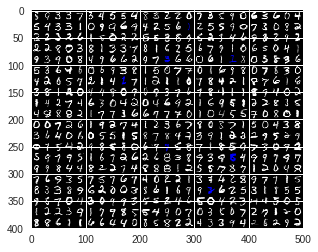

In [12]:
### TRAIN DIGITS
import cv2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



SZ = 20
CLASS_N = 10

# local modules
# from common import clock, mosaic

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

class StatModel(object):
    def load(self, fn):
        self.model.load(fn)  # Known bug: https://github.com/opencv/opencv/issues/4969
    def save(self, fn):
        self.model.save(fn)

class SVM(StatModel):
    def __init__(self, C = 12.5, gamma = 0.50625):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):

        return self.model.predict(samples)[1].ravel()


def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('Accuracy: %.2f %%' % ((1 - err)*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        
        vis.append(img)
    return mosaic(25, vis)

def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0


def get_hog() : 
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR


    
#The main function. 

if __name__ == '__main__':

    print('Loading digits from digits.png ... ')
    # Load data.
    digits, labels = load_digits('digits.png')
    
   

    print('Shuffle data ... ')
    # Shuffle data
    rand = np.random.RandomState(10)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]
    
    print('Deskew images ... ')
    digits_deskewed = list(map(deskew, digits))
    
    print('Defining HoG parameters ...')
    # HoG feature descriptor
    hog = get_hog();

    print('Calculating HoG descriptor for every image ... ')
    hog_descriptors = []
    for img in digits_deskewed:
        hog_descriptors.append(hog.compute(img))
    hog_descriptors = np.squeeze(hog_descriptors)

    print('Spliting data into training (90%) and test set (10%)... ')
    train_n=int(0.9*len(hog_descriptors))
    digits_train, digits_test = np.split(digits_deskewed, [train_n])
    hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])
    
    
    print('Training SVM model ...')
    model = SVM()
    model.train(hog_descriptors_train, labels_train)

    print('Saving SVM model ...')
    model.save('digits_svm.dat')


    print('Evaluating model ... ')
    vis = evaluate_model(model, digits_test, hog_descriptors_test, labels_test)
    cv2.imwrite("digits-classification.jpg",vis)
    plt.imshow(vis, cmap="gray")
    plt.show()




## LOADING AND SEEING THE DATA

Loading digits from digits.png ... 


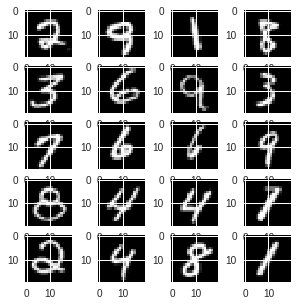

In [103]:

print('Loading digits from digits.png ... ')
# Load data.
digits, labels = load_digits('digits.png')
# print(digits[0])


plt.figure(figsize=(5,5))

import random 

col = 1
row = 0
for i in range(20):
  if (i % 5 == 0):
    col = 1
    row += 1
  else :
    col += 1
  
  index = random.randint(0,digits.shape[0])
  plt.subplot( 5, 4, i+1 )
  plt.imshow(digits[index], cmap="gray")

plt.show()
  


# plt.imshow(digits[0], cmap="gray")
# plt.show()

## Shuffle the data before training 

Shuffle data ... 


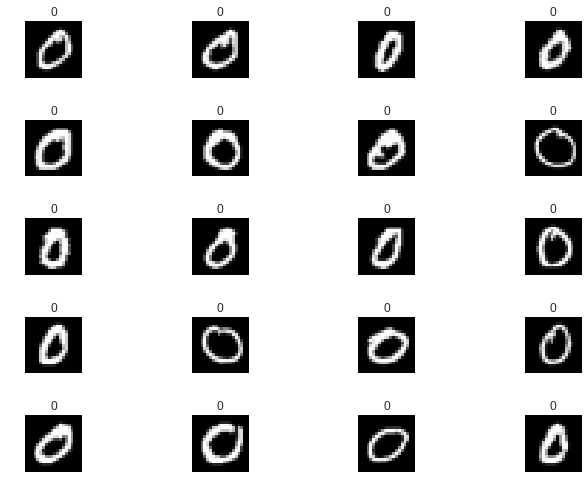

In [104]:
print('Shuffle data ... ')
# Shuffle data
# rand = np.random.RandomState(10)
# shuffle = rand.permutation(len(digits))
# digits, labels = digits[shuffle], labels[shuffle]


f = plt.figure(figsize=(10,7))

for i in range(20):


  plt.subplot( 5, 4, i+1 )
  plt.axis('off')
  plt.imshow(digits[i], cmap="gray")
  plt.title(labels[i])
plt.tight_layout( w_pad=0.5, h_pad=1.0)
plt.show()



## Aligin images to veritical before training 

Deskew images ... 


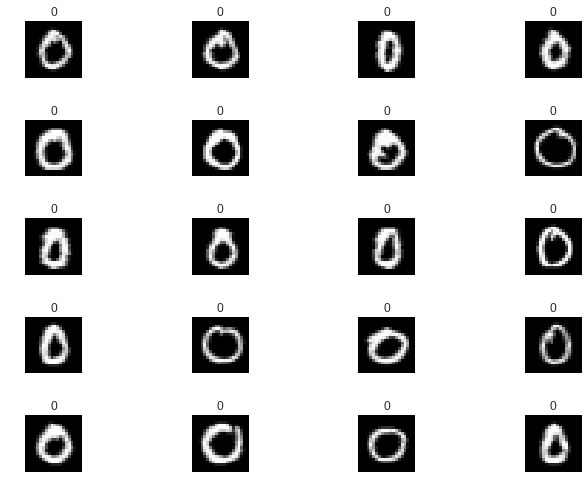

In [105]:
print('Deskew images ... ')
digits_deskewed = list(map(deskew, digits))

f = plt.figure(figsize=(10,7))

for i in range(20):


  plt.subplot( 5, 4, i+1 )
  plt.axis('off')

  plt.imshow(digits_deskewed[i], cmap="gray")
  plt.title(labels[i])

plt.tight_layout( w_pad=0.5, h_pad=1.0)

plt.show()

## Calculating HOG Descriptor



In [106]:
print('Defining HoG parameters ...')
# HoG feature descriptor
hog = get_hog();

print('Calculating HoG descriptor for every image ... ')
hog_descriptors = []
for img in digits_deskewed:
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)

Defining HoG parameters ...
Calculating HoG descriptor for every image ... 


## Splitting the data into training and test set 

(20, 20)

In [107]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hog_descriptors, labels, test_size = 0.3, random_state = 10)
print("Training size", X_train.shape[0])
print("Testing Size" , X_test.shape[0])

Training size 3500
Testing Size 1500


## Training the model 


In [108]:
from sklearn.svm import SVC

model = SVC(kernel = "rbf", C = 50, gamma =0.50625)

model.fit(X_train, y_train)
preds = model.predict(X_test)


from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, preds, labels = np.arange(0,10))
print("Confusion matrix")
print(mat)

print("Accuracy:" , model.score(X_test, y_test))

Confusion matrix
[[150   0   0   0   0   0   1   0   0   0]
 [  0 142   1   0   0   0   0   1   0   0]
 [  0   1 164   0   0   0   0   0   1   0]
 [  0   0   1 148   0   0   0   1   1   0]
 [  0   0   0   0 147   0   1   0   0   3]
 [  0   0   0   1   0 142   0   1   1   0]
 [  0   0   1   0   0   0 128   0   0   0]
 [  0   4   0   1   0   0   0 148   1   3]
 [  0   0   0   0   0   0   0   0 160   1]
 [  1   0   0   0   1   0   0   2   1 140]]
Accuracy: 0.9793333333333333


We got an accuracy of 97.9% on a simple SVM algorithm with a simple dataset. 
This tells that the HOG descriptors work very well for different shapes and sizes. 

This is easier to code and work with. 

## References :

1. https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/